In [65]:
import os
from typing import  List
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3

from yaml import load
from yaml import SafeLoader
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langgraph.prebuilt import ToolNode
from langchain_core.messages import ToolMessage
import json
import logging
from io import BytesIO
from typing import Annotated, Literal
from langchain_openai import ChatOpenAI
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from openai import OpenAI
from typing_extensions import TypedDict
import openai
from typing import Optional
os.environ["OPENAI_API_KEY"] = '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'

In [66]:
from langchain_core.prompts import ChatPromptTemplate




In [126]:
INITIAL_PROMPT = """
You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:{weight}
HEIGHT:{tall}
GOAL:{goal}
intensity:{intensity}
age:{age}
sex:{sex}
Equipment: local gym
 **Avoid repeating the same movement pattern within a body part.**
 **Prioritize **variety** and **muscle group balance**.

1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.
2. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
3. Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - Weekly split is one main body part each day
4. be clear and concise.

NOTIFIY THE USER WHETHER THE DATABASE RETUREND THE CORRECT ANSWER OR NOT
IMPORTANT:
make sure the plan is 6 exercises for back and chest and shoulder 
8 exercises for arms and leg
and 5 for core 
make sure that primary muscle and sub muscle you search are in this massage list

- Focus on muscle groups from the following comprehensive lists:
Body parts: Back, Chest, Leg, Shoulders, Arms
dont forget the lower back
PRIMARY MUSCLE names:
:[
    'Biceps Brachii', 'Brachialis', 'Brachioradialis', 'Deltoid', 'Gluteus Maximus', 'Hamstrings',
    'Deltoid Lateral', 'biceps', 'brachialis', 'brachioradialis', 'chest', 'Anterior Deltoids',
    'Lateral Deltoids', 'Triceps Brachii', 'Upper Pectorals', 'Pectoralis Major', 'Triceps',
    'Latissimus Dorsi', 'Trapezius', 'Rhomboids', 'Deltoids', 'biceps femoris', 'semitendinosus',
    'semimembranosus', 'quads', 'glutes', 'Chest', 'Shoulders', 'Core', 'Rear Deltoids',
    'Rotator Cuff', 'Posterior Deltoids', 'Quadriceps', 'Hips', 'Gluteal muscles', 'Front Deltoids',
    'Lateral Deltoid', 'Rear Deltoid', 'Pectoralis', 'Pectoralis major', 'Erector Spinae',
    'adductors', 'inner thigh muscles', 'Lower Back', 'Middle Back', 'Gastrocnemius', 'Soleus',
    'lower back', 'Gluteus Medius', 'Gluteus Minimus', 'calves', 'Spinal Erectors',
    'forearm extensors', 'back', 'Pectoral muscles', 'Chest muscles', 'Medial Deltoid',
    'Serratus Anterior', 'Middle delts', 'Rear delts', 'Traps', 'Rectus Femoris', 'Vastus Medialis',
    'Back muscles', 'forearm muscles', 'latissimus dorsi', 'Wrist Flexor', 'Wrist Flexors',
    'Lateral Deltoids', 'Posterior Deltoids', 'Latissimus dorsi', 'Lower trapezius',
    'Pectoralis Minor', 'Pectoralis Major - Clavicular Head', 'Multifidus', 'lats', 'traps',
    'Vastus Lateralis', 'Vastus Intermedius', 'legs', 'Upper Back', 'Middle Trapezii',
    'Lower Trapezii', 'Teres Major', 'Teres Minor', 'Infraspinatus', 'delts', 'pecs',
    'Thenar muscles', 'Finger Flexors', 'Pectoral (Chest) Muscles'
]

SECONDARY MUSCLE names:
'abdominal muscles', 'abdominals', 'abductors', 'abs', 'adductor brevis', 'adductor longus', 'adductor magnus', 'adductors', 'ankle stabilizers', 
'anterior deltoid', 'anterior deltoids', 'arm muscles', 'arms', 'back', 'back muscles', 'biceps', 'biceps brachii', 'brachialis', 'brachioradialis',
'branchialis', 'calf muscles', 'calves', 'chest', 'core', 'core muscles', 'core musculature', 'deep core muscles', 'deltoids', 'elbow flexors', 'erector
spinae', 'erectors', 'external oblique', 'external obliques', 'forearm', 'forearm flexors', 'forearm flexors and extensors', 'forearm muscles', 'forearms',
'gastrocnemius', 'gluteus maximus', 'glutes', 'grip muscles', 'hamstrings', 'hands', 'hip flexors', 'hips', 'infraspinatus', 'inner thighs', 'lateral deltoid', 'lateral deltoids', 'lats', 'legs', 
'levator scapulae', 'lower back', 'lower back muscles', 'lower leg', 'lower traps', 'multifidus', 'neck', 'obliques', 'outer thighs', 'pecs', 'posterior deltoids',
'posterior delts', 'posterior oblique sling', 'postural muscles', 'quadriceps', 'quads', 'rear deltoids', 'rectus abdominis', 'rhomboid major', 'rhomboid minor',
'rhomboids', 'rotator', 'rotator cuff muscles', 'scapular', 'serratus anterior', 'shoulder stabilizers', 'shoulders', 'soleus', 'spinal erectors', 
'stabilizing muscles', 'teres major', 'teres minor', 'thighs', 'tibialis anterior', 'transverse abdominis', 'trapezius', 'traps', 'triceps',
'triceps brachii', 'upper back', 'upper back muscles', 'upper body', 'upper chest', 'upper pectoralis', 'upper traps', 'wrist extensor', 
'wrist extensors', 'wrist flexors'
"""


In [ ]:
JUDGE_PROMPT = """
You are a fitness program evaluator. Your task is to assess the quality, accuracy, and completeness of a workout program generated by a fitness coach AI.

Evaluate the following workout plan according to these criteria:

1. **Exercise Count Validation**:
   - Back: exactly 6 exercises
   - Chest: exactly 6 exercises
   - Shoulders: exactly 6 exercises
   - Arms: exactly 8 exercises
   - Legs: exactly 8 exercises
   - Core: exactly 5 exercises

2. **Muscle Group Coverage**:
   - Ensure each listed body part targets both **primary** and **secondary** muscle groups.
   - Verify that **lower back** is included as a target at least once, preferably on Back or Legs day.

3. **Variety & Movement Pattern Check**:
   - Ensure that there is **no repetition of the same movement pattern** (e.g., multiple types of horizontal rows or vertical presses) within a single muscle group day.
   - Confirm **variety in exercises** to promote balanced muscle development.

4. **Format Consistency**:
   - Each exercise must include: **name**, **primary muscles**, **secondary muscles**, **sets**, and **reps**.
   - Plan must be clean, structured, and easy to read.

5. **Feedback on Plan**:
   - If all criteria are met: respond with `"VALID PLAN"` and give a short praise.
   - If criteria are not met: respond with `"INVALID PLAN"` and clearly explain **which criteria were violated** and how to fix them.

Review the plan below and return your evaluation:
===
{plan}
===
"""


In [128]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        message.pretty_print()

In [129]:
config = load(open("config.yaml"), Loader=SafeLoader)
os.environ["GROQ_API_KEY"] = config["groq"]["apiKey"]
from langchain_groq import ChatGroq


In [130]:
from langchain.tools import tool
connection = sqlite3.connect("work_out.db")
@tool
def get_exercises(body_part: str, primary_muscles: str, secondary_muscles: str) -> list:
    """
    Fetches exercises from the SQLite database based on primary and sub muscle.

    Args:
        body_part (str): The body part to filter exercises by.
        primary_muscles (str): Primary muscle group targeted.
        secondary_muscle (str): Secondary muscle group targeted.

    
    Returns:
        str: A formatted string listing matching exercises, one per line.
    """
    primary_muscles = primary_muscles.lower().strip()
    secondary_muscles = secondary_muscles.lower().strip()
    body_part = body_part.lower().strip()
    body_part_modified = body_part[:-1] if body_part.endswith('s') else body_part

    connection = sqlite3.connect("work_out.db")
    cursor = connection.cursor()
    query = f"""
        SELECT exercise,primary_muscles,secondary_muscles 
        FROM DATASET
        WHERE (primary_muscles LIKE '%{primary_muscles}%' 
               OR secondary_muscles LIKE '%{secondary_muscles}%')
        AND body_part = '{body_part_modified}'
        LIMIT 5;
    """
    parameters = (f"%{primary_muscles}%", f"%{secondary_muscles}%", body_part_modified)
    cursor.execute(query)
    rows = cursor.fetchall()
    connection.close()
    if not rows:
        return "no exercises found"
    exercise_details = []
    for i, (name, prim, sec) in enumerate(rows, 1):
        # Ensure retrieved data is treated as string and cleaned
        name_str = str(name).strip() if name else "Unknown Exercise"
        prim_str = str(prim).strip() if prim else "N/A"
        sec_str = str(sec).strip() if sec else "N/A" # Handle empty secondary muscles
        exercise_details.append(
            f"{i}. {name_str}\n   Primary: {prim_str}\n   Secondary: {sec_str}"
        )
    # Join the formatted strings with newlines for the final output
    formatted_output = "\n ".join(exercise_details)
    return f"Found these exercises:\n{formatted_output}"
    
    


In [131]:
connection = sqlite3.connect("work_out.db")
cursor = connection.cursor()
query = """
    SELECT DISTINCT body_part
    FROM DATASET

"""
cursor.execute(query)
rows = cursor.fetchall()
connection.close()

In [132]:
tools_route = [
    {
        "type": "function",
        "function": {
            "name": "get_exercises",
            "description": "Fetches exercises from the database based on body part and muscles.",
            "parameters": {
                "type": "object",
                "properties": {
                    "body_part": {
                        "type": "string",
                        "description": "The body part to filter exercises by (e.g. 'arms', 'legs')."
                    },
                    "primary_muscles": {
                        "type": "string",
                        "description": "Primary muscle group targeted (e.g. 'biceps')."
                    },
                    "secondary_muscles": {
                        "type": "string",
                        "description": "Secondary muscle group targeted (e.g. 'forearms')."
                    }
                },
                "required": ["body_part", "primary_muscles", "secondary_muscles"]
            }
        }
    }
]


In [133]:
tools=[get_exercises]

In [134]:

# llm = ChatGroq(
#     model="llama-3.3-70b-versatile",
#     temperature=0.1,
#     max_tokens=None,
#     timeout=None,
#     max_retries=2,
# ).bind_tools(tools)

llm = ChatGroq(
    model="meta-llama/llama-4-maverick-17b-128e-instruct",
    temperature=0.1,
    max_tokens=None,
    timeout=None,
    max_retries=2,
).bind_tools(tools)

In [135]:
tool_node=ToolNode(tools)

In [136]:
class State(TypedDict):
    messages: Annotated[list,add_messages]
    summary_plan: str

In [137]:
# def should_continue(state: State) -> Literal["tools", "summary"]:  # Changed "summary" to "end"
#     messages = state["messages"]
#     last_message = messages[-1]
    
#     # Only continue to tools if there are active tool calls
#     if hasattr(last_message, "tool_calls") and last_message.tool_calls:
#         return "tools"
#     return   "summary"



In [138]:
def should_continue(state: State) -> Literal["tools", END]:  # Changed "summary" to "end"
    messages = state["messages"]
    last_message = messages[-1]
    
    # Only continue to tools if there are active tool calls
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    return END  



In [139]:
summary_prompt = """ Summarize the workout plan in a nice and clean format"""

In [140]:
openai_client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  
)

In [141]:
llm2=ChatOpenAI(model="meta-llama/llama-4-maverick:free",base_url="https://openrouter.ai/api/v1")



In [142]:
#llm=llm2.bind_tools(tools)

In [143]:
llm.invoke("what exercises traget chest and biceps")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_aefx', 'function': {'arguments': '{"body_part": "chest", "primary_muscles": "pectoralis major", "secondary_muscles": "anterior deltoids"}', 'name': 'get_exercises'}, 'type': 'function'}, {'id': 'call_h47j', 'function': {'arguments': '{"body_part": "arm", "primary_muscles": "biceps brachii", "secondary_muscles": "brachialis"}', 'name': 'get_exercises'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 301, 'prompt_tokens': 363, 'total_tokens': 664, 'completion_time': 1.3222244619999999, 'prompt_time': 0.015234712, 'queue_time': 0.123342896, 'total_time': 1.337459174}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_190e1a8b22', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9795a83d-3c52-4b6c-97af-879ad6aea4b8-0', tool_calls=[{'name': 'get_exercises', 'args': {'body_part': 'chest', 'primary_muscles': 'pectoralis major', 'secondary_muscles

In [144]:
def call_model(state: State):
    
    print("you are in call model ")
    messages = state["messages"]
    
    
    for i, msg in enumerate(messages):
        if isinstance(msg, ToolMessage) and not isinstance(msg.content, str):
            messages[i] = ToolMessage(
                tool_call_id=msg.tool_call_id,
                content=json.dumps(msg.content)
            )


    response = llm.invoke(messages)
    return {"messages": [response]}

In [145]:
def call_judge(state: State):
    print("you are in call judge ")
    messages = state["messages"]
    messages.append( judge_prompt)
    judge =llm.invoke(messages)
    print("you are near end ")
    return {
        "messages": messages,
        "judge": judge,
    }

In [146]:
def summary_node(state: State):
    print("you are in summary ")
    messages = state["messages"]
    messages.append( summary_prompt)
    summarize =llm.invoke(messages)
    print("you are near end ")

    return {
        "messages": messages,
        "summary_plan": summarize,
    }

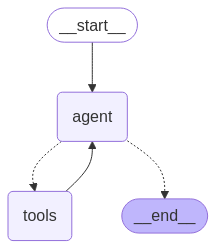

In [147]:
workflow = StateGraph(State)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
#workflow.add_node("summary", summary_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")
#workflow.add_edge("summary", END)
checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [148]:
INITIAL_PROMPT=INITIAL_PROMPT.format(weight=90, tall=180,goal="get lean muscle",sex="male",age=25,intensity="high")

In [149]:
from langchain_core.runnables.config import RunnableConfig


In [150]:
config = {
    "recursion_limit": 70,
    "configurable": {
        "thread_id": 78,
        # You might have other keys here depending on your setup,
        # especially if using specific checkpointers, e.g.:
        # "checkpoint_ns": "your_namespace",
        # "user_id": "some_user_identifier",
    }
}


In [151]:
inputs = {"messages": [("user", INITIAL_PROMPT)]}
print_stream(graph.stream(inputs, config, stream_mode="values"))
# Start chatbot


================================ Human Message =================================


You are a professional fitness coach.

Your mission is to help people reach their fitness goals by:
- Analyzing their current fitness level, body weghit and height

WEGHIT:90
HEIGHT:180
GOAL:get lean muscle
intensity:high
age:25
sex:male
Equipment: local gym
 **Avoid repeating the same movement pattern within a body part.**
 **Prioritize **variety** and **muscle group balance**.

1.Use your knowledge and tools to search for relevant exercises from a database
   and determine optimal sets, reps, and intensity based on the user's goals.
   search one primary muscle group and one sub-muscle group at a time.
2. Allow for feedback, adjustments, and improvements based on user input or
   progress tracking.
3. Output the full program in a clean, structured format that includes:
   - Exercises with primary/secondary muscle groups
   - Instructions, sets, reps, and variations
   - Weekly split is one main body pa

In [152]:
print("you are near end ")

you are near end 


In [153]:
get_exercises.invoke({"body_part": "Arm", "primary_muscles": "Erector Spinae", "secondary_muscles": "Hamstrings"})

"Found these exercises:\n1. Kickbacks (Dumbbell or Cable)\n   Primary: ['Triceps Brachii']\n   Secondary: ['Gluteus Maximus', 'Hamstrings', 'Lower Back Muscles']\n 2. Farmer’s Carry\n   Primary: ['forearms', 'shoulders', 'upper back', 'trapezius', 'core', 'glutes']\n   Secondary: ['biceps', 'triceps', 'quadriceps', 'hamstrings', 'calves', 'lower back', 'obliques', 'transverse abdominis', 'rectus abdominis', 'chest']"

In [154]:


# while True:
#     user_input = input("User: ")
#     inputs = {"messages": [("user", user_input)]}
#     print_stream(graph.stream(inputs, config, stream_mode="values"))

In [155]:
graph.get_state({"thread_id": 78}).values["messages"].content

KeyError: 'configurable'

In [ ]:
latex_code=llm.invoke()

In [1]:
import subprocess
import os

latex_code = r"""
\documentclass{article}
\usepackage{geometry}
\geometry{a4paper, margin=1in} % Optional: Adjust margins
\usepackage{amsmath} % Include if you need math environments, otherwise optional
\usepackage{amssymb} % Optional: for extra symbols
\usepackage{enumitem} % Optional: for more control over lists
\usepackage{hyperref} % Optional: for clickable links

\begin{document}

\section*{6-Day Workout Plan Summary}

\subsection*{Day 1: Back}
\begin{itemize}
    \item \textbf{Pull-Ups}: Sets: 4, Reps: 8-12
    \item \textbf{Bent-Over Barbell Rows}: Sets: 4, Reps: 8-12
    \item \textbf{Lat Pulldown}: Sets: 3, Reps: 12-15
    \item \textbf{Seated Cable Rows}: Sets: 3, Reps: 12-15
    \item \textbf{Face Pulls}: Sets: 3, Reps: 12-15
    \item \textbf{Reverse Flyes (Dumbbell or Machine)}: Sets: 3, Reps: 12-15
\end{itemize}

\subsection*{Day 2: Chest}
\begin{itemize}
    \item \textbf{Barbell Bench Press}: Sets: 4, Reps: 8-12
    \item \textbf{Incline Barbell Bench Press}: Sets: 4, Reps: 8-12
    \item \textbf{Dumbbell Bench Press}: Sets: 3, Reps: 12-15
    \item \textbf{Cable Chest Flys}: Sets: 3, Reps: 12-15
    \item \textbf{Incline Cable Flys}: Sets: 3, Reps: 12-15
    \item \textbf{Push-Ups}: Sets: 3, Reps: 12-15
\end{itemize}

\subsection*{Day 3: Legs}
\begin{itemize}
    \item \textbf{Back Squat}: Sets: 4, Reps: 8-12
    \item \textbf{Front Squat}: Sets: 4, Reps: 8-12
    \item \textbf{Leg Press}: Sets: 3, Reps: 12-15
    \item \textbf{Lunges (Walking or Stationary)}: Sets: 3, Reps: 12-15 (per leg)
    \item \textbf{Step-Ups (Weighted or Bodyweight)}: Sets: 3, Reps: 12-15 (per leg)
    \item \textbf{Calf Raises}: Sets: 4, Reps: 15-20
\end{itemize}

\subsection*{Day 4: Shoulders}
\begin{itemize}
    \item \textbf{Barbell Overhead Press}: Sets: 4, Reps: 8-12
    \item \textbf{Dumbbell Shoulder Press}: Sets: 4, Reps: 8-12
    \item \textbf{Lateral Raises}: Sets: 3, Reps: 12-15
    \item \textbf{Face Pulls}: Sets: 3, Reps: 12-15
    \item \textbf{Reverse Flyes (Dumbbell or Machine)}: Sets: 3, Reps: 12-15
    \item \textbf{Front Raises}: Sets: 3, Reps: 12-15
\end{itemize}

\subsection*{Day 5: Arms}
\begin{itemize}
    \item \textbf{Barbell Bicep Curl}: Sets: 4, Reps: 8-12
    \item \textbf{Dumbbell Bicep Curl}: Sets: 4, Reps: 8-12
    \item \textbf{Hammer Curls}: Sets: 3, Reps: 12-15
    \item \textbf{Triceps Pushdown}: Sets: 4, Reps: 8-12
    \item \textbf{Overhead Dumbbell Extension}: Sets: 3, Reps: 12-15
    \item \textbf{Skull Crushers}: Sets: 3, Reps: 8-12
    \item \textbf{Preacher Curl}: Sets: 3, Reps: 12-15
    \item \textbf{Tricep Dips}: Sets: 3, Reps: 12-15
\end{itemize}

\subsection*{Day 6: Core}
\begin{itemize}
    \item \textbf{Plank}: Sets: 3, Hold for 30-60 seconds
    \item \textbf{Russian Twists}: Sets: 3, Reps: 12-15
    \item \textbf{Leg Raises}: Sets: 3, Reps: 12-15
    \item \textbf{Bicycle Crunches}: Sets: 3, Reps: 12-15
    \item \textbf{Superman}: Sets: 3, Reps: 12-15
\end{itemize}

\end{document}
"""
with open("output2.tex", "w", encoding="utf-8") as f:
    f.write(latex_code)
pdflatex_path = r"C:\Users\Hossa\AppData\Local\Programs\MiKTeX\miktex\bin\x64\pdflatex.exe"
try:
  
    print("Compiling LaTeX file...")
    result = subprocess.run([pdflatex_path, "output2.tex"], cwd=os.getcwd(), check=True, capture_output=True, text=True)
    print("LaTeX compilation successful.")
    print("pdflatex output:")
    print(result.stdout)
    if result.stderr:
        print("pdflatex errors/warnings:")
        print(result.stderr)

except FileNotFoundError:
    print(f"Error: pdflatex executable not found at '{pdflatex_path}'. Please check the path.")
except subprocess.CalledProcessError as e:
    print(f"Error during LaTeX compilation: {e}")
    print("pdflatex output:")
    print(e.stdout)
    print("pdflatex errors/warnings:")
    print(e.stderr)
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Compiling LaTeX file...
LaTeX compilation successful.
pdflatex output:
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (MiKTeX 24.1) (preloaded format=pdflatex.fmt)
 restricted \write18 enabled.
entering extended mode
(output2.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-04>
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\Hossa\AppData\Local\Programs\MiKTeX\tex/latex/amsmath\amsmath.sty
For additional infor

In [ ]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [ ]:
class single_exercise(BaseModel):
    exercise: str = Field(description="exercise name")
    sub_muscles: list [str] = Field(description="list of sub_muscle in this exercise")
    primary_muscles:list [ str] = Field(description="list of primary muscle in this exercise")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    instruction: str = Field(description="exercise instruction")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"
class single_body_part(BaseModel):
    body_part: str = Field(description="name of the body part")
    exercises: List[single_exercise] = Field(description="list of exercises in this body part")
    @property
    def summary(self):
        return f"body_part: {self.body_part}, exercises: {self.exercises}"
#structed_output_llm=llm.with_structured_output(single_body_part)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# Define the prompt template with proper input variables
fitness_instructions = ChatPromptTemplate.from_template("""
You are tasked with generating a list of exercises for {body_part} that the user needs to train. Follow these instructions carefully:

1. First, review the Goal: {Goal} and the height and weight of {tall}cm and {weight}kg then specify the level of {the_level_of_cardio}.
    
2. Examine any editorial feedback: {human_feedback}

3. Take notes on the level of {intensity}

4. You can search the database for exercises by using tools

{input}
{agent_scratchpad}""")  # Required for tool calling

# Construct the tool calling agent
agent = create_tool_calling_agent(
    llm=llm,
    tools=tools,
    prompt=fitness_instructions
)

In [ ]:
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True,max_iterations=3)

response = agent_executor.invoke({
    "body_part": "back",
    "Goal": "gain muscle",
    "intensity": "moderate",
    "tall": 180,
    "weight": 70,
    "the_level_of_cardio": "medium",
    "human_feedback": "",
    "input": "Generate workout exercises for back",
})



> Entering new AgentExecutor chain...

Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']
Invoking: `get_exercises` with `{'body_part': 'back', 'primary_muscles': 'latissimus dorsi', 'secondary_muscles': 'trapezius'}`


['Chin-Ups', 'Behind-the-Neck Pulldown']

> Finished chain.


In [ ]:
response

{'body_part': 'back',
 'Goal': 'gain muscle',
 'intensity': 'moderate',
 'tall': 180,
 'weight': 70,
 'the_level_of_cardio': 'medium',
 'human_feedback': '',
 'input': 'Generate workout exercises for back',
 'output': 'Agent stopped due to max iterations.'}

In [ ]:
class Generate_plans(TypedDict):
    goal:str # goal of the workout_plans
    intensity: str # intensity of the workout
    tall: int 
    weight: int
    human_feedback: str
    max_exercises: int
    muscle_workouts: List[MainMuscle] # list of whole body exercise

In [ ]:
import langchain_core

In [ ]:
fitness_instructions="""You are tasked with retreiving and review a set of exercises for each muscle group. Follow these instructions carefully:

1. First, review the research topic:
{goal}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. Assign one set of exercises to each main muscle group.
5. Pick the top {max_exercises} exercises for each SUB muscle group."""


In [ ]:
def create_plans(state: Generate_plans):
    
    """ Create plans """
    print("i am here")
    goal=state.get('goal', '')
    intensity=state.get('intensity', '')
    human_feedback=state.get('human_feedback', '')
    max_exercises=state.get('max_exercises', 0)    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = fitness_instructions.format(goal=goal,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,max_exercises=max_exercises)

    # Generate question 
    main_muscle_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="serach the set of exercises with serach_by_sub_muscle_tool and enhance it.")])
    
    # Write the list of analysis to state
    return {"muscle_workouts": main_muscle_plans}

In [ ]:
def search_exercises(main: str = None, sub: str = None):
    cursor = connection.cursor()
    cursor.execute(
        """
        SELECT * 
        FROM exercises
        WHERE sub_muscles LIKE ?
        OR main_muscle LIKE ?;
        """,
        (f"%{sub}%", f"%{main}%")
    )
    rows = cursor.fetchall()
    print("I am here")
    # Display the results
    return rows


In [ ]:
def human_feedback_nod(state: Generate_plans):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: Generate_plans):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(Generate_plans)
builder.add_node("create_plans", create_plans)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

NameError: name 'Generate_plans' is not defined

In [ ]:
# Input
max_exercises = 2
goal = "lose weight"
intessity = "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"goal":goal,"max_exercises":max_exercises,"instensity":intessity}, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here
('muscle_workouts', [{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])


In [ ]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_exercises': 2, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis Major', 'Pectoralis Minor'], 'exercise': ['Bench Press', 'Dumbbell Press', 'Incline Press']}, {'main_muscle': 'Back', 'sub_muscle': ['Latissimus Dorsi', 'Trapezius'], 'exercise': ['Pull-ups', 'Lat Pulldowns', 'Rows']}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps', 'Hamstrings'], 'exercise': ['Squats', 'Lunges', 'Leg Press']}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids', 'Rotator Cuff'], 'exercise': ['Shoulder Press', 'Lateral Raises', 'Rear Delt Fly']}, {'main_muscle': 'Arms', 'sub_muscle': ['Biceps', 'Triceps'], 'exercise': ['Bicep Curls', 'Tricep Pushdowns', 'Overhead Dumbbell Extension']}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb9e79-7665-6672-8001-cbe35fa2ccc6'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'mus